# ICC Profiles in Python

This notebook explores three TIFF images and their relationship to ICC Profiles.

The images are originally from an SVS file (CMU-1.svs from openslide.org), extracted using ImageScope in three ways:

* ICC profile applied
* ICC profile embedded
* ICC profile ignored

In [1]:
import numpy as np
import io
from PIL import Image, ImageCms
from matplotlib import pyplot as plt
from pathlib import Path
from imageio.v3 import imread

path = Path('./images')

## Read & Compare

Read the images using imageio, using whatever the default options are.

Then calculate some basic stats and display them for comparison.

I'd expect that the 'applied' ICC profile image will be different from the others - but still want to make sure that the embedded profile isn't being applied during reading.

In [2]:
path_apply = path / 'CMU-Apply.tif'
path_embed = path / 'CMU-Embed.tif'
path_ignore = path / 'CMU-Ignore.tif'

im_apply = imread(path_apply)
im_embed = imread(path_embed)
im_ignore = imread(path_ignore)

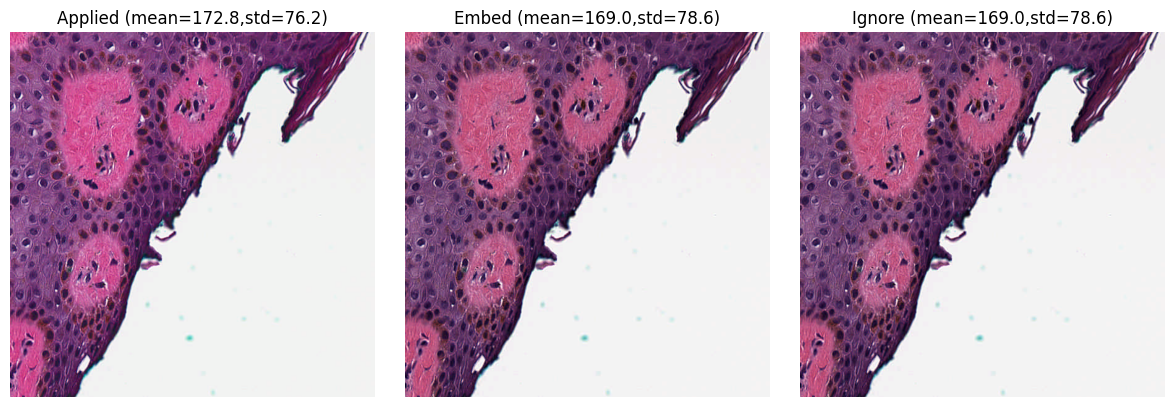

In [3]:
def show_images(**kwargs):
    count = 0
    plt.figure(figsize=(len(kwargs)*4, 4))
    for name, im in kwargs.items():
        count += 1
        plt.subplot(1, len(kwargs), count)
        plt.imshow(im)
        plt.axis(False)
        plt.title(f'{name} (mean={im.mean():.1f},std={im.std():.1f})')
    plt.tight_layout()
    plt.show()
    
show_images(Applied=im_apply, Embed=im_embed, Ignore=im_ignore)

The appearances are all pretty similar, but the one with the transformed 'applied' looks pinker to me.

We can confirm that `im_embed` and `im_ignore` have the same pixel values, while `im_apply` and `im_ignore` are different:

In [4]:
def compare_images(im1: np.ndarray, im2: np.ndarray):
    if np.all(im1 == im2):
        return 'Images are identical'
    else:
        im_diff = im1.astype(np.float32) - im2.astype(np.float32)
        return f'Images are different (mean={im_diff.mean():.2f}, std={im_diff.std():.2f}, mad={np.abs(im_diff).mean():.2f})'

print(f'im_embed and im_ignore: {compare_images(im_embed, im_ignore)}')
print(f'im_apply and im_ignore: {compare_images(im_apply, im_ignore)}')

im_embed and im_ignore: Images are identical
im_apply and im_ignore: Images are different (mean=3.85, std=6.72, mad=5.16)


## Extract ICC profile

ICC profiles can be extracted and applied with the help of [Pillow](https://pillow.readthedocs.io/en/stable/reference/ImageCms.html).

In [5]:
def read_icc(path) -> bytes:
    with Image.open(path) as image:
        return image.info.get('icc_profile')
    return icc

# We expect not to have profiles for 'apply' and 'ignore'
assert read_icc(path_apply) == None
assert read_icc(path_ignore) == None

# We should have one for 'embed'
icc_bytes = read_icc(path_embed)
assert icc_bytes != None

## Apply ICC profile transform

To apply the transform, we need to define the source and target ICC profiles.

As far as I understand it, the embedded profile should be the source and sRGB is a sensible default for the target.

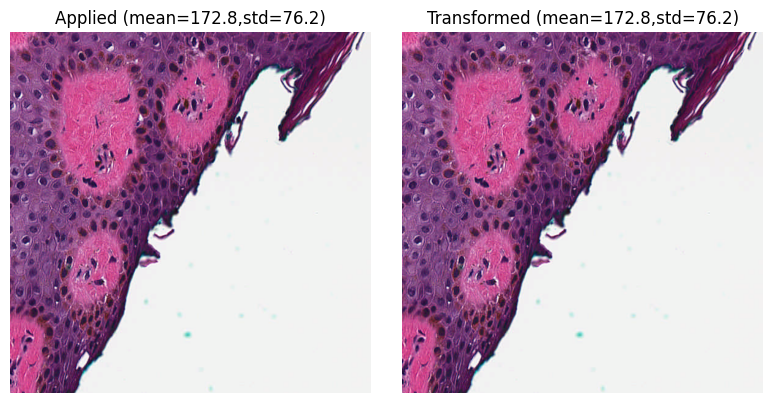

im_apply and im_transformed: Images are different (mean=0.02, std=0.33, mad=0.08)


In [6]:
def apply_icc(im: np.ndarray, icc_source, icc_target, **kwargs) -> np.ndarray:
    transform = ImageCms.buildTransformFromOpenProfiles(icc_source, icc_target, inMode='RGB', outMode='RGB', **kwargs)
    image = Image.fromarray(im)
    image = ImageCms.applyTransform(image, transform)
    return np.array(image)

icc_srgb = ImageCms.createProfile('sRGB')

im_transformed = apply_icc(im_ignore, io.BytesIO(icc_bytes), icc_srgb)

show_images(Applied=im_apply, Transformed=im_transformed)

print(f'im_apply and im_transformed: {compare_images(im_apply, im_transformed)}')

The image with the transformed applied in ImageScope is very similar to the image transformed here... but not quite identical.

We can visualize the difference with a histogram.

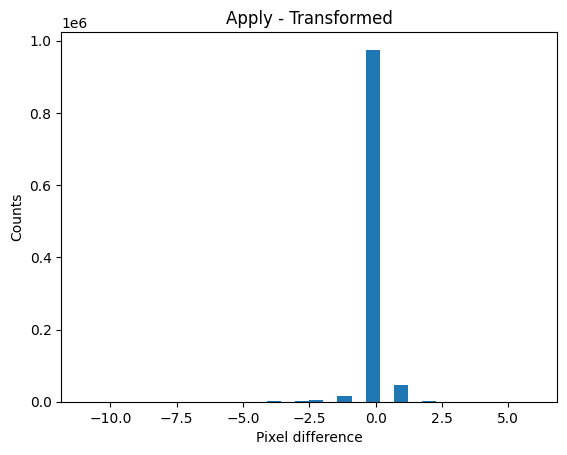

In [7]:
def show_difference_hist(im1: np.ndarray, im2: np.ndarray, title: str = None, bins=32):
    im_diff = im1.astype(np.float32) - im2.astype(np.float32)
    plt.hist(im_diff.ravel(), bins=bins)
    plt.xlabel('Pixel difference')
    plt.ylabel('Counts')
    if title:
        plt.title(title)
    plt.show()
    
show_difference_hist(im_apply, im_transformed, 'Apply - Transformed')

## Explore alternatives

Because the results aren't identical, we can try to test we didn't get something wrong along the way.

Firstly, maybe I misunderstood and we have the *target* ICC profile and not the source.
So we can swap the order to check that.

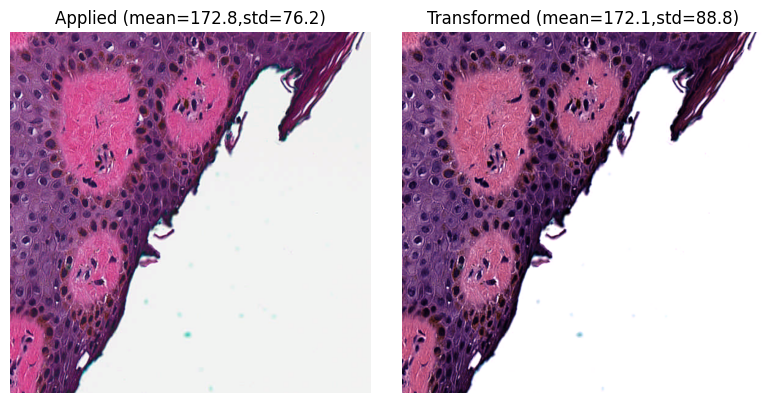

im_apply and im_transformed: Images are different (mean=0.72, std=15.68, mad=14.39)


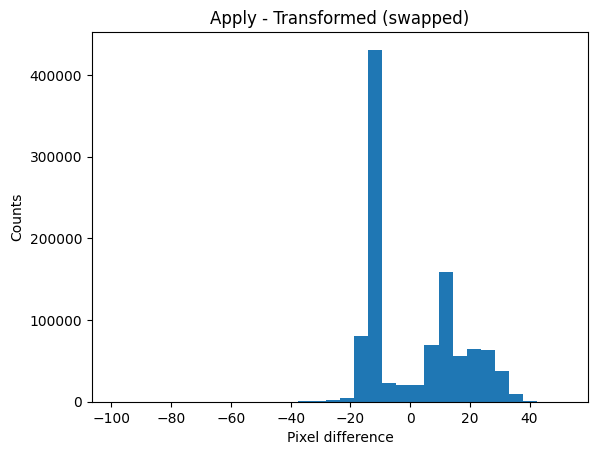

In [8]:
# Switched source and target (expected to be wrong!)
im_transformed_swapped = apply_icc(im_ignore, icc_srgb, io.BytesIO(icc_bytes))

show_images(Applied=im_apply, Transformed=im_transformed_swapped)

print(f'im_apply and im_transformed: {compare_images(im_apply, im_transformed_swapped)}')

show_difference_hist(im_apply, im_transformed_swapped, 'Apply - Transformed (swapped)')

The image looks plausible, but comparison with the ImageScope output demonstrates that something is off.

So that convinces me that the embedded profile should be provided as the source.

## Rendering intent

There are also ['rendering intent'](https://pillow.readthedocs.io/en/stable/reference/ImageCms.html#PIL.ImageCms.buildProofTransformFromOpenProfiles) options to explore, which can take values between 0 and 3.

We can check what the defaults are for our profiles, and if they match `Intent.PERCEPTUAL` (the default for our transform).

In [9]:
from PIL.ImageCms import Intent

print(f'Source profile rendering intent: {ImageCms.getDefaultIntent(io.BytesIO(icc_bytes))}')
print(f'Target profile rendering intent: {ImageCms.getDefaultIntent(icc_srgb)}')

print(f'Intent.PERCEPTUAL: {Intent.PERCEPTUAL}')

Source profile rendering intent: 0
Target profile rendering intent: 0
Intent.PERCEPTUAL: 0


So probably we can't improve things by changing the `Intent`, but it's still worth a try.

To confirm, let's loop through the intents and make sure no option does better.

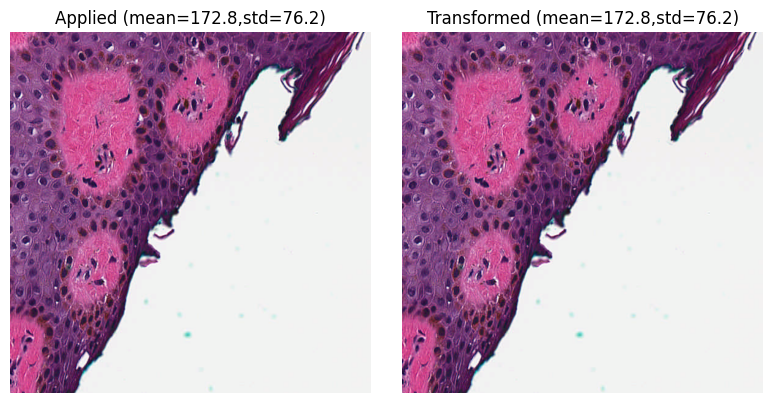

im_apply and im_transformed (intent=0): Images are different (mean=0.02, std=0.33, mad=0.08)


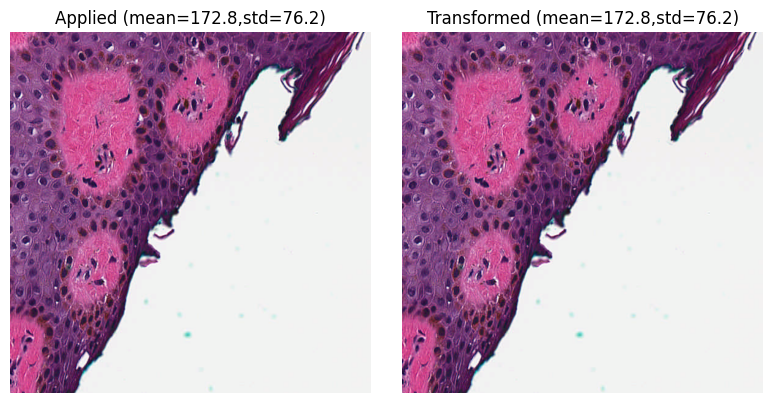

im_apply and im_transformed (intent=1): Images are different (mean=0.02, std=0.33, mad=0.08)


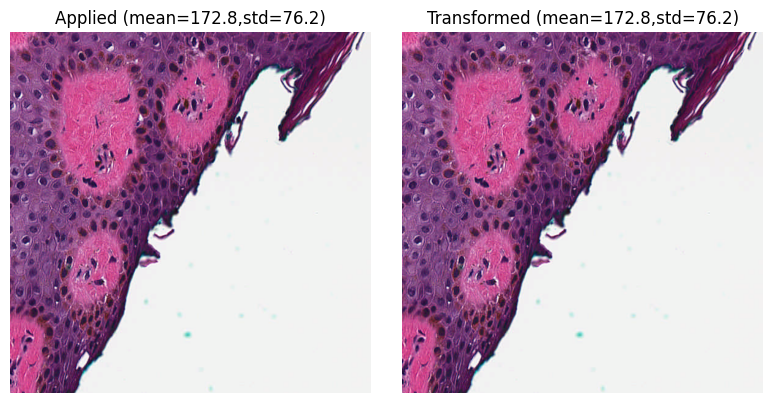

im_apply and im_transformed (intent=2): Images are different (mean=0.02, std=0.33, mad=0.08)


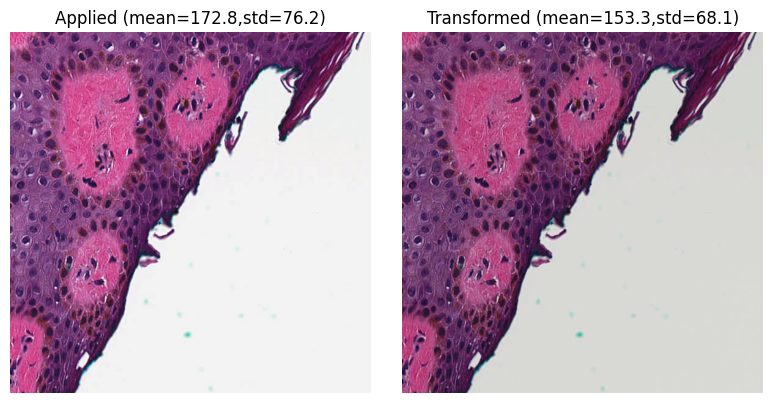

im_apply and im_transformed (intent=3): Images are different (mean=19.54, std=8.19, mad=19.55)


In [10]:
all_intents = (Intent.PERCEPTUAL, Intent.RELATIVE_COLORIMETRIC, Intent.SATURATION, Intent.ABSOLUTE_COLORIMETRIC)

for intent in all_intents:
    im_transformed = apply_icc(im_ignore, io.BytesIO(icc_bytes), icc_srgb,
                               renderingIntent=intent)

    show_images(Applied=im_apply, Transformed=im_transformed)

    print(f'im_apply and im_transformed (intent={intent}): {compare_images(im_apply, im_transformed)}')


Changing the intent *can* make a difference, but no improvement over the default.

## Conclusions

It seems that taking the embedded ICC profile as the source and using `Intent.PERCEPTUAL` is able to transform the image in a way that is similar to how ImageScope does it.

The results aren't identical, although the [Wikipedia article on ICC Profiles](https://en.wikipedia.org/wiki/ICC_profile) gives a hint as to why that might be:

> The ICC defines the format precisely but does not define algorithms or processing details. This means there is room for variation between different applications and systems that work with ICC profiles.

Still, I'd be curious as to whether anyone else has a solution.

Meanwhile, we can further explore just how different the results are.

Percentage of pixels that are the same: 93.4%


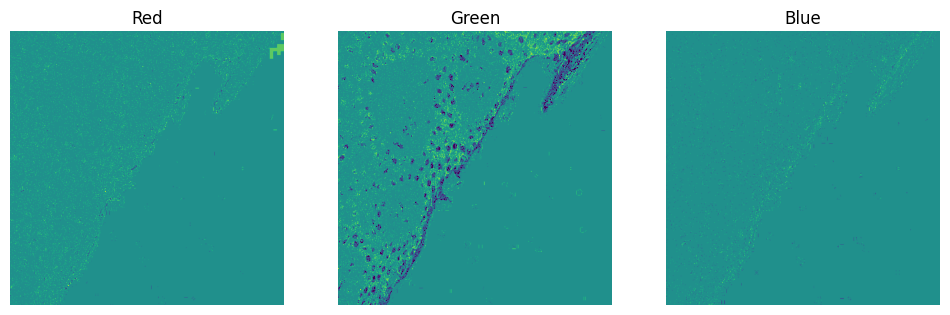

In [11]:
im_transformed = apply_icc(im_ignore, io.BytesIO(icc_bytes), icc_srgb, renderingIntent=Intent.PERCEPTUAL)

percent_same = np.mean(im_apply == im_transformed) * 100
print(f'Percentage of pixels that are the same: {percent_same:.1f}%')

im_diff = im_apply.astype(np.float32) - im_transformed.astype(np.float32)

plt.figure(figsize=(12, 4))
titles = ('Red', 'Green', 'Blue')
for ii in range(3):
    plt.subplot(1, 3, ii+1)
    plt.imshow(im_diff[..., ii], vmin=-2, vmax=2)
    plt.title(titles[ii])
    plt.axis(False)
plt.show()

I think that's pretty similar...